<a href="https://colab.research.google.com/github/criscarmor/TFG-CCM/blob/main/DEFINITIVO_Predicci%C3%B3n_no_secuenciales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este Notebook se encarga de generar los datasets necesarios para entrenar los distintos modelos. Para entrenar el modelo de stacking lógicamente hay primero que obtener los modelos de 1 hora y 24 horas.

Para comenzar hay que subir 2 archivos:

*   **X_data_final.csv** (donde X indica el contaminante)
*   **clima_data_final.csv** (archivo con los datos de clima horarios)

En la primera línea de código, elegir la estación objetivo de estudio y el contaminante. Hay que tener en cuenta que no todas las estaciones están disponibles para todos los contaminantes.

*   **NO2**: [9, 10, 15, 16, 17, 18, 19]
*   **O3**: [9, 15, 17, 18, 19]
*   **SO2**: [9, 10, 16, 18, 19]
*   **PM10**: [9, 15, 16, 18]
*   **PM25**: [9, 10, 15]



In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
estacion = 10
contaminante = 'PM25'

In [ ]:
parametros = {
    'NO2': [0.24, 200, 0.2],
    'O3' : [0.18, 120, 0.79],
    'PM10' : [0.28, 50, 0.25],
    'PM25' : [0.36, 25, 0.50]
}

In [ ]:
def merge_por_estacion(df_contaminacion, df_clima):

    estaciones = df_contaminacion['ESTACION'].unique()
    resultados = {}

    for est in estaciones:
        df_est = df_contaminacion[df_contaminacion['ESTACION'] == est]
        df_merged = df_est.merge(df_clima, left_index=True, right_index=True, how='inner')
        df_merged.drop(columns=['ESTACION'], inplace=True)
        resultados[est] = df_merged

    return resultados

In [ ]:
def detectar_bloques_continuos(df, min_horas=25):
    """
    Detecta bloques de tiempo consecutivo (1h de diferencia entre filas)
    con al menos `min_horas` observaciones.
    """
    df = df.sort_index()
    idx = df.index

    # Calcular diferencias entre fechas
    dif = idx.to_series().diff().fillna(pd.Timedelta(hours=1))
    corte = dif != pd.Timedelta(hours=1)

    # Etiquetar bloques de continuidad
    bloques = corte.cumsum()

    # Agrupar por bloques y filtrar los que tienen duración suficiente
    bloques_validos = []
    for _, grupo in df.groupby(bloques):
        if len(grupo) >= min_horas:
            bloques_validos.append(grupo)

    return bloques_validos

In [ ]:
def generar_lags_globales(df, variables_lag, target_col='CONCENTRACION', n_lags=24):
    df = df.copy()

    # Target es el valor de la hora siguiente
    df['target'] = df[target_col].shift(-1)

    # Valor naive: el valor actual de la variable objetivo
    df['naive'] = df[target_col]

    # Generar lags para cada variable
    for var in variables_lag:
        for lag in range(1, n_lags + 1):
            df[f'{var}_lag{lag}'] = df[var].shift(lag)

    df = df.dropna()

    return df



In [ ]:
def generar_lags_globales_completos(df, variables_lag, target_col='CONCENTRACION', n_lags=24):
    df = df.copy()

    for var in variables_lag:
        for lag in range(1, n_lags + 1):
            df[f'{var}_lag{lag}'] = df[var].shift(lag)

    for h in range(1, n_lags + 1):
        df[f'{h}_target'] = df[target_col].shift(-h)
        df[f'{h}_naive'] = df[target_col].shift(h - 1)  # paso a paso

    df = df.dropna()
    return df


In [ ]:

def predecir_24h_iterativo(modelo, X_bloque, y_bloque, target='CONCENTRACION', horizon=24, mostrar=False):
    X_temp = X_bloque.copy()
    predicciones = []
    reales = []

    for h in range(horizon):
        X_actual = X_temp.iloc[[h]]
        y_real = y_bloque.iloc[h]

        y_pred = modelo.predict(X_actual)[0]
        predicciones.append(y_pred)
        reales.append(y_real)

        if mostrar:
            print(f"\nIteración h = {h}")
            print(f"Predicción para t = {h + 1}: {y_pred:.2f}")
            lags_usados = {col: X_actual.iloc[0][col] for col in X_actual.columns if 'CONCENTRACION_lag' in col}
            print("Lags de CONCENTRACION usados como input:", lags_usados)

        # Actualizar NO2 para t+1
        if h + 1 < len(X_temp):
            if mostrar:
                print(f"Sustituyendo X_temp.loc[{h + 1}, '{target}'] con {y_pred:.2f}")
            X_temp.loc[h + 1, target] = y_pred

        # Actualizar lags de NO2 para filas futuras
        for col in X_actual.columns:
            if 'CONCENTRACION_lag' in col:
                try:
                    lag_num = int(col.split('lag')[1])
                    fila_objetivo = h + 1 + lag_num
                    if fila_objetivo < len(X_temp):
                        if mostrar:
                            print(f"Actualizando lag '{col}' en fila {fila_objetivo} con valor {y_pred:.2f}")
                        X_temp.loc[fila_objetivo, col] = y_pred
                except:
                    continue

        if mostrar:
            print("-" * 60)

    return predicciones, reales




In [ ]:
def calcular_RMSu(parametros, media, std):
  primero = (1-parametros[2]**2)*(media**2 + std**2)
  segundo = (parametros[2]**2)*(parametros[1]**2)
  return parametros[0]*np.sqrt(primero + segundo)


#Carga de datos


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv(contaminante + "_data_final.csv", index_col=0, parse_dates=True)
df

,ESTACION,CONCENTRACION,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos
FECHA_HORA,,,,,,,,
2021-01-01 00:00:00,9.0,13.78,0.000000,1.000000,-0.433884,-0.900969,5.000000e-01,0.866025
2021-01-01 01:00:00,9.0,12.72,0.258819,0.965926,-0.433884,-0.900969,5.000000e-01,0.866025
2021-01-01 02:00:00,9.0,9.54,0.500000,0.866025,-0.433884,-0.900969,5.000000e-01,0.866025
2021-01-01 03:00:00,9.0,7.42,0.707107,0.707107,-0.433884,-0.900969,5.000000e-01,0.866025
2021-01-01 04:00:00,9.0,4.24,0.866025,0.500000,-0.433884,-0.900969,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,15.0,33.35,-0.965926,0.258819,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 20:00:00,15.0,40.25,-0.866025,0.500000,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 21:00:00,15.0,40.25,-0.707107,0.707107,-0.781831,0.623490,-2.449294e-16,1.000000


In [ ]:
df_clima = pd.read_csv("clima_data_final.csv", index_col=0, parse_dates=True)
df_clima

,temp,dwpt,rhum,wspd,prcp,wdir_sin,wdir_cos
FECHA_HORA,,,,,,,
2014-01-02 00:00:00,13.900000,13.3,97.000000,11.2,0.0,-6.427876e-01,-0.766044
2014-01-02 01:00:00,13.966667,13.3,96.666667,12.4,0.0,-6.838732e-01,-0.724959
2014-01-02 02:00:00,14.033333,13.3,96.333333,13.6,0.0,-7.249588e-01,-0.683873
2014-01-02 03:00:00,14.100000,13.3,96.000000,14.8,0.0,-7.660444e-01,-0.642788
2014-01-02 04:00:00,14.000000,14.0,100.000000,13.0,0.0,-5.000000e-01,-0.866025
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,9.500000,9.5,100.000000,7.6,0.0,5.000000e-01,0.866025
2023-12-31 20:00:00,9.300000,9.3,100.000000,3.6,0.0,1.736482e-01,0.984808
2023-12-31 21:00:00,7.900000,7.9,100.000000,5.4,0.0,-2.449294e-16,1.000000


In [ ]:
df_estaciones = merge_por_estacion(df, df_clima)

# Cálculo de cutoff


In [ ]:
cutoff_2023 = pd.Timestamp("2023-01-01 00:00:00")

In [ ]:
df = df_estaciones[estacion][df_estaciones[estacion].index < cutoff_2023].copy()
df_2023 = df_estaciones[estacion][df_estaciones[estacion].index >= cutoff_2023 + pd.Timedelta(days=2)].copy()

In [ ]:
fechas_unicas = df.index.unique().sort_values()

# Calcular posición correspondiente al 80%
pos_cutoff = int(len(fechas_unicas) * 0.8)

# Obtener la fecha de cutoff (el punto que divide el 80% inicial del tiempo)
cutoff = fechas_unicas[pos_cutoff]
cutoff_siguiente_dia = (cutoff + pd.Timedelta(days=1)).replace(hour=0, minute=0, second=0)
print(cutoff_siguiente_dia)


2022-08-08 00:00:00


In [ ]:
df = df.sort_index()
rango_completo = pd.date_range(df.index.min(), df.index.max(), freq='H')
df = df.reindex(rango_completo)


/tmp/ipython-input-211-597869227.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rango_completo = pd.date_range(df.index.min(), df.index.max(), freq='H')


In [ ]:
df_2023 = df_2023.sort_index()
rango_completo_2023 = pd.date_range(df_2023.index.min(), df_2023.index.max(), freq='H')
df_2023 = df_2023.reindex(rango_completo_2023)


/tmp/ipython-input-212-1875725589.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rango_completo_2023 = pd.date_range(df_2023.index.min(), df_2023.index.max(), freq='H')


# Generación de dataset para la hora siguiente

In [ ]:
variables_lag = ['CONCENTRACION', 'temp', 'dwpt', 'rhum', 'wspd', 'wdir_cos', 'wdir_sin', 'prcp']
#variables_ciclicas = ['hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos', 'mes_sin', 'mes_cos']
df_gboost_lags24_1hora = generar_lags_globales(df, variables_lag, target_col='CONCENTRACION', n_lags=24)
df_2023_gboost_lags24_1hora = generar_lags_globales(df_2023, variables_lag, target_col='CONCENTRACION', n_lags=24)

/tmp/ipython-input-4-1208151384.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag{lag}'] = df[var].shift(lag)
/tmp/ipython-input-4-1208151384.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag{lag}'] = df[var].shift(lag)
/tmp/ipython-input-4-1208151384.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

In [ ]:
cutoff1 = cutoff_siguiente_dia
cutoff2 = cutoff1 + pd.Timedelta(days=2)
#cutoff2 = pd.Timestamp("2021-03-01 00:00:00")

# Dividir el dataset
df_train = df_gboost_lags24_1hora[df_gboost_lags24_1hora.index < cutoff1].copy()
df_test = df_gboost_lags24_1hora[df_gboost_lags24_1hora.index >= cutoff2].copy()

# Mostrar rango de fechas para confirmación
print(f"Train: {df_train.index.min()} → {df_train.index.max()}")
print(f"Test:  {df_test.index.min()} → {df_test.index.max()}")

Train: 2021-01-02 00:00:00 → 2022-08-07 23:00:00
Test:  2022-08-10 00:00:00 → 2022-12-31 22:00:00


In [ ]:
lags = [col for col in df_train.columns if 'lag' in col]
ciclicas = ['hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos', 'mes_sin', 'mes_cos']
climaticas = ['temp', 'dwpt', 'rhum', 'wspd', 'wdir_sin', 'wdir_cos','prcp']
features = lags + ciclicas + climaticas + ['CONCENTRACION']

In [ ]:
X_train = df_train[features]
y_train = df_train['target']
y_naive_train = df_train['naive']
X_test = df_test[features]
y_test = df_test['target']
y_naive_test = df_test['naive']


In [ ]:
X_2023 = df_2023_gboost_lags24_1hora[features]
y_2023 = df_2023_gboost_lags24_1hora['target']
y_naive_2023 = df_2023_gboost_lags24_1hora['naive']

# Generación de dataset para predicción múltiple

In [ ]:
variables_lag = ['CONCENTRACION', 'temp', 'dwpt', 'rhum', 'wspd', 'wdir_cos', 'wdir_sin', 'prcp']
df_gboost_lags24_24horas = generar_lags_globales_completos(df, variables_lag, target_col='CONCENTRACION', n_lags=24)
df_2023_gboost_lags24_24horas = generar_lags_globales_completos(df_2023, variables_lag, target_col='CONCENTRACION', n_lags=24)

/tmp/ipython-input-5-3008221463.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag{lag}'] = df[var].shift(lag)
/tmp/ipython-input-5-3008221463.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag{lag}'] = df[var].shift(lag)
/tmp/ipython-input-5-3008221463.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fr

In [ ]:
cutoff1 = cutoff_siguiente_dia
cutoff2 = cutoff1 + pd.Timedelta(days=2)
# Dividir el dataset
df_train = df_gboost_lags24_24horas[df_gboost_lags24_24horas.index < cutoff1].copy()
df_test = df_gboost_lags24_24horas[df_gboost_lags24_24horas.index >= cutoff2].copy()

# Mostrar rango de fechas para confirmación
print(f"Train: {df_train.index.min()} → {df_train.index.max()}")
print(f"Test:  {df_test.index.min()} → {df_test.index.max()}")

Train: 2021-01-02 00:00:00 → 2022-08-07 23:00:00
Test:  2022-08-10 00:00:00 → 2022-12-30 23:00:00


In [ ]:
lags = [col for col in df_train.columns if '_lag' in col]
naive = [col for col in df_train.columns if '_naive' in col]
targets = [f'{i}_target' for i in range(1, 25)]
ciclicas = ['hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos', 'mes_sin', 'mes_cos']
climaticas = ['temp', 'dwpt', 'rhum', 'wspd', 'wdir_sin', 'wdir_cos', 'prcp']
features = lags + ciclicas + climaticas + ['CONCENTRACION']

In [ ]:
X_train_24 = df_train[features]
y_train_24 = df_train[targets]
y_naive_train_24 = df_train[naive]
X_test_24 = df_test[features]
y_test_24 = df_test[targets]
y_naive_test_24 = df_test[naive]

In [ ]:
X_24_2023 = df_2023_gboost_lags24_24horas[features]
y_24_2023 = df_2023_gboost_lags24_24horas[targets]
y_naive_24_2023 = df_2023_gboost_lags24_24horas[naive]

#ElasticNet y TabNet

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit

def entrenar_evaluar_elasticnet(X_train, y_train, X_test, y_test, X_2023, y_2023):
    resultados = {}
    tscv = TimeSeriesSplit(n_splits=5)
    model = ElasticNetCV(
        cv=tscv,
        l1_ratio=[0.1, 0.5, 0.9, 1.0],
        alphas=[0.01, 0.1, 1.0, 10.0],
        max_iter=10000,
        random_state=42
    )

    # Entrenar
    model.fit(X_train, y_train)

    mejores_hiperparametros = {
        'alpha': model.alpha_,
        'l1_ratio': model.l1_ratio_
    }
    resultados['mejores_hiperparametros'] = mejores_hiperparametros

    print(f"Mejor alpha seleccionado: {model.alpha_}")
    print(f"Mejor l1_ratio seleccionado: {model.l1_ratio_}")

    # Evaluar en validación final (2023)
    y_pred_2023 = model.predict(X_2023)
    resultados['validacion_2023'] = {
        'RMSE': np.sqrt(mean_squared_error(y_2023, y_pred_2023)),
        'MAE': mean_absolute_error(y_2023, y_pred_2023),
        'R2': r2_score(y_2023, y_pred_2023),
        'MASE': mean_absolute_error(y_2023, y_pred_2023) / mean_absolute_error(y_2023, y_naive_2023),
        'R2_naive': r2_score(y_2023, y_naive_2023)
    }


    # Coeficientes del modelo
    coeficientes = pd.Series(model.coef_, index=X_train.columns)

    return model, resultados, coeficientes





In [ ]:
model, resultados, coef = entrenar_evaluar_elasticnet(
    X_train, y_train, X_test, y_test, X_2023, y_2023
)

print(resultados)
print(coef.sort_values(ascending=False))


🔍 Mejor alpha seleccionado: 0.01
🔍 Mejor l1_ratio seleccionado: 0.5
{'mejores_hiperparametros': {'alpha': np.float64(0.01), 'l1_ratio': np.float64(0.5)}, 'validacion_2023': {'RMSE': np.float64(0.37244514205627066), 'MAE': 0.21588088273066422, 'R2': 0.7346485414222806, 'MASE': 1.3870985416281658, 'R2_naive': 0.6735566833209663}}
CONCENTRACION          0.643967
CONCENTRACION_lag22    0.045512
CONCENTRACION_lag2     0.034359
CONCENTRACION_lag23    0.033972
CONCENTRACION_lag1     0.023241
                         ...   
wdir_cos_lag5         -0.003968
temp_lag23            -0.005273
wspd                  -0.006042
dwpt                  -0.007242
temp_lag10            -0.015482
Length: 206, dtype: float64


In [ ]:
def entrenar_evaluar_tabnet_con_mase(X_train, y_train, X_test, y_test, X_2023, y_2023, max_epochs=100, frecuencia_naive=1):
    from pytorch_tabnet.tab_model import TabNetRegressor
    from sklearn.preprocessing import StandardScaler

    resultados = {}

    # Escalar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_2023_scaled = scaler.transform(X_2023)

    # Formateo
    y_train_2d = y_train.values.reshape(-1, 1)

    # Modelo TabNet
    model = TabNetRegressor(
        verbose=0,
        seed=42
    )

    model.fit(
        X_train=X_train_scaled, y_train=y_train_2d,
        eval_set=[(X_test_scaled, y_test.values.reshape(-1, 1))],
        eval_metric=['rmse'],
        max_epochs=max_epochs,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128
    )

    # Predicción
    y_pred_test = model.predict(X_test_scaled).ravel()
    y_pred_2023 = model.predict(X_2023_scaled).ravel()

    # Métricas


    resultados['validacion_2023'] = {
        'RMSE': np.sqrt(mean_squared_error(y_2023, y_pred_2023)),
        'MAE': mean_absolute_error(y_2023, y_pred_2023),
        'R2': r2_score(y_2023, y_pred_2023),
        'MASE': mean_absolute_error(y_2023, y_pred_2023) / mean_absolute_error(y_2023, y_naive_2023)
    }

    return model, resultados, scaler



In [ ]:


modelo_tabnet, resultados_tabnet, scaler_tabnet = entrenar_evaluar_tabnet_con_mase(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_2023=X_2023,
    y_2023=y_2023,
    max_epochs=100,
    frecuencia_naive=1
)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_rmse = 7.40948


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:

print("\nResultados en validación final (2023):")
for k, v in resultados_tabnet['validacion_2023'].items():
    print(f"{k}: {v:.3f}")



Resultados en validación final (2023):
RMSE: 5.677
MAE: 4.006
R2: 0.855
MASE: 1.263


# Modelo XGBoost con 24 horas anteriores para predecir la hora siguiente

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# -------------------------
# 1. Dividir X_train para búsqueda de hiperparámetros
# -------------------------
split_index = int(len(X_train) * 0.9)
X_subtrain, X_subval = X_train[:split_index], X_train[split_index:]
y_subtrain, y_subval = y_train[:split_index], y_train[split_index:]

# -------------------------
# 2. Grid Search en X_subtrain / X_subval
# -------------------------
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'colsample_bytree': [1.0, 0.8]
}

xgb_base = XGBRegressor(
    objective='reg:squarederror',
    subsample=1.0,
    random_state=42
)

cv = [(np.arange(len(X_subtrain)), np.arange(len(X_subtrain), len(X_subtrain) + len(X_subval)))]
X_grid = pd.concat([X_subtrain, X_subval], axis=0)
y_grid = pd.concat([y_subtrain, y_subval], axis=0)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_grid, y_grid)

modelo_1h = grid_search.best_estimator_
y_pred_2023 = modelo_1h.predict(X_2023)

rmse = np.sqrt(mean_squared_error(y_2023, y_pred_2023))
mae = mean_absolute_error(y_2023, y_pred_2023)
mae_naive = mean_absolute_error(y_2023, y_naive_2023)
mase = mae / mae_naive
r2 = r2_score(y_2023, y_pred_2023)
#RMSu = calcular_RMSu(parametros[contaminante], np.mean(y_2023), np.std(y_2023))
#MQI = rmse/(2*RMSu)

print(" Mejores hiperparámetros:", grid_search.best_params_)
print(" RMSE (2023):", round(rmse, 3))
print(" MAE  (2023):", round(mae, 3))
print(" R²   (2023):", round(r2, 3))
print(" MASE   (2023):", round(mase, 3))
#print(" MQI   (2023):", round(MQI, 3))

Fitting 1 folds for each of 16 candidates, totalling 16 fits
✅ Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
📊 RMSE (2023): 3.253
📊 MAE  (2023): 2.122
📊 R²   (2023): 0.894
📊 MASE   (2023): 0.987


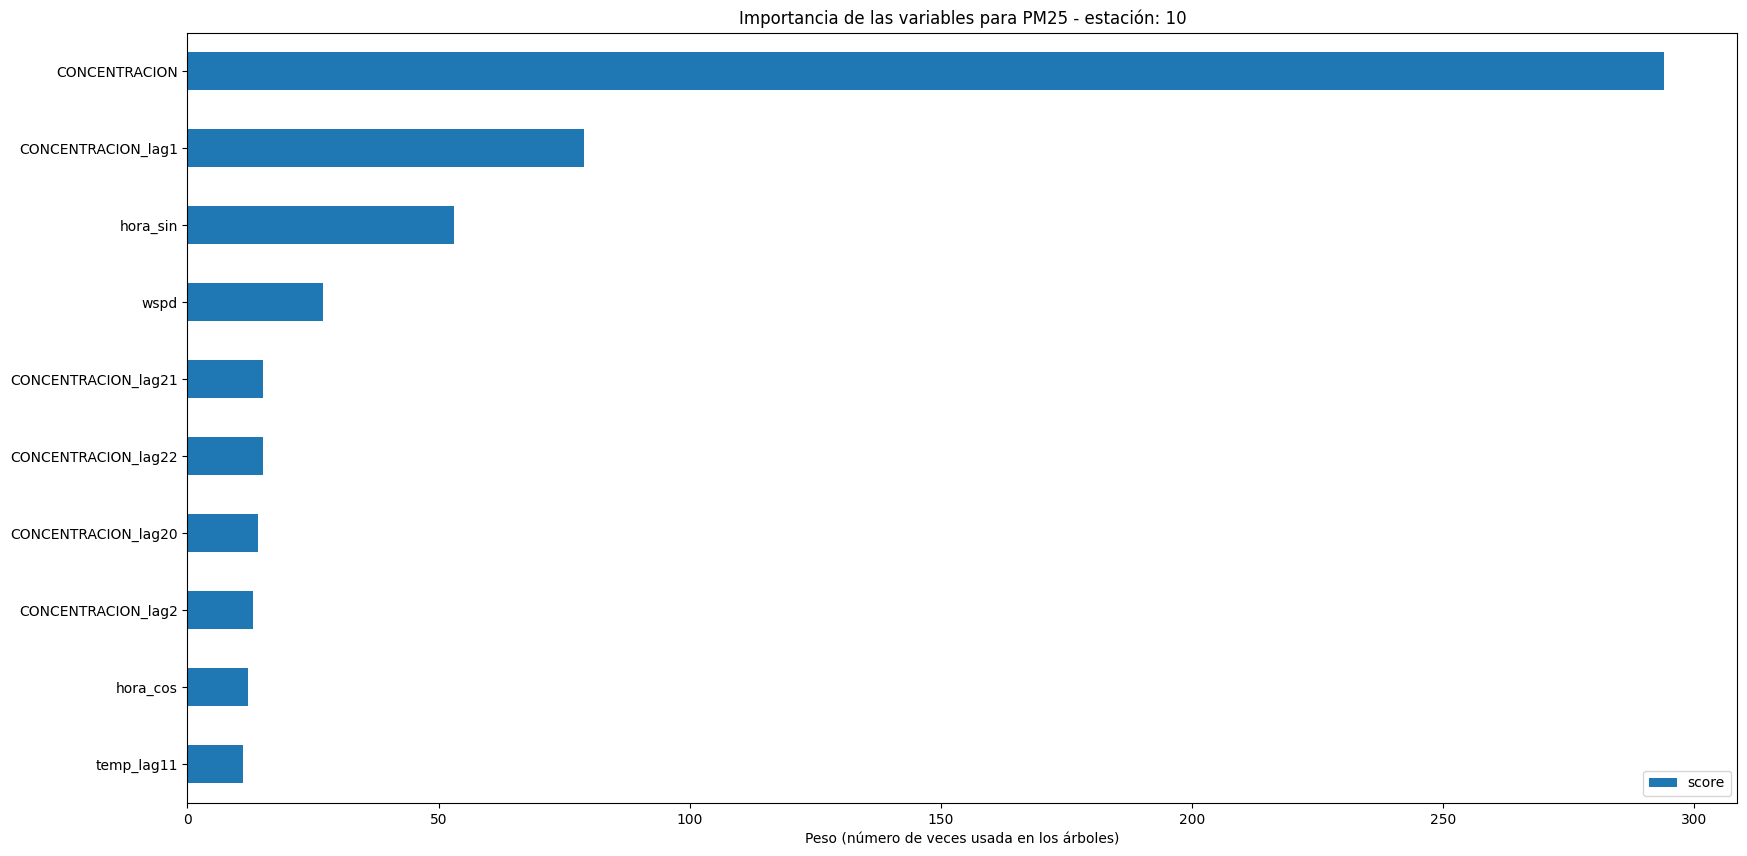

In [ ]:
import matplotlib.pyplot as plt

feature_important = modelo_1h.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

# Crear DataFrame
data = pd.DataFrame(data=values, index=keys, columns=["score"])

# Ordenar de mayor a menor
data = data.sort_values(by="score", ascending=False)

# Graficar las 10 más importantes
ax = data.nlargest(10, columns="score").plot(kind='barh', figsize=(20, 10))
plt.title("Importancia de las variables para " + contaminante +" - estación: "+ str(estacion))
plt.xlabel("Peso (número de veces usada en los árboles)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
y_pred = modelo_1h.predict(X_test)

In [ ]:
bloques = detectar_bloques_continuos(y_2023, 361)
bloque_primero = bloques[0]

In [ ]:
bloque = bloques[0]

indices_bloque = bloque.index

posiciones = y_2023.index.get_indexer(indices_bloque)

predicciones_bloque = y_pred_2023[posiciones]

In [ ]:
y_pred_series_2023 = pd.Series(predicciones_bloque[:360], index=indices_bloque[:360])

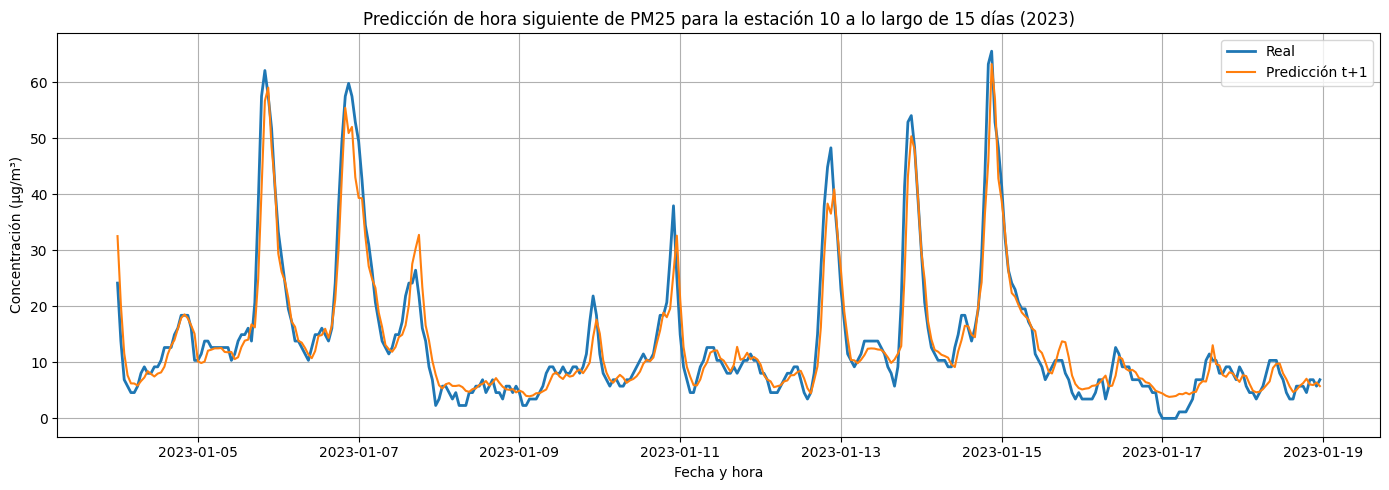

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(bloque[:360], label='Real', linewidth=2)
plt.plot(y_pred_series_2023, label='Predicción t+1')
plt.title("Predicción de hora siguiente de " + contaminante +" para la estación " + str(estacion) + " a lo largo de 15 días (2023)")
plt.xlabel("Fecha y hora")
plt.ylabel("Concentración (μg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Modelo XGBoost con 24 horas anteriores para predecir 24 horas siguientes


In [ ]:
from sklearn.multioutput import MultiOutputRegressor

base_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

modelo_multi = MultiOutputRegressor(base_model)
modelo_multi.fit(X_train_24, y_train_24)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [ ]:
y_pred_24 = modelo_multi.predict(X_test_24)

In [ ]:
y_pred_24_2023 = modelo_multi.predict(X_24_2023)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.mean([
    np.sqrt(mean_squared_error(y_24_2023.iloc[:, i], y_pred_24_2023[:, i]))
    for i in range(24)
])
mae = np.mean([
    mean_absolute_error(y_24_2023.iloc[:, i], y_pred_24_2023[:, i])
    for i in range(24)
])
r2 = np.mean([
    r2_score(y_24_2023.iloc[:, i], y_pred_24_2023[:, i])
    for i in range(24)
])

mase = np.mean([
    mean_absolute_error(y_24_2023.iloc[:, i], y_pred_24_2023[:, i]) /
    mean_absolute_error(y_24_2023.iloc[:, i], y_naive_24_2023.iloc[:, i])
    for i in range(24)
])

'''RMSu_h = [
    calcular_RMSu(parametros[contaminante], np.mean(y_24_2023.iloc[:, i]), np.std(y_24_2023.iloc[:, i]))
    for i in range(24)
]

# MQI por horizonte
mqi_h = [
    np.sqrt(mean_squared_error(y_24_2023.iloc[:, i], y_pred_24_2023[:, i])) / (2 * RMSu_h[i])
    for i in range(24)
]

# MQI promedio
mqi = np.mean(mqi_h)'''

print(f"Promedio RMSE: {rmse:.3f}")
print(f"Promedio MAE: {mae:.3f}")
print(f"Promedio R²: {r2:.3f}")
print(f"Promedio MASE: {mase:.3f}")
#print(f"Promedio MQI: {mqi:.3f}")

Promedio RMSE: 7.488
Promedio MAE: 4.712
Promedio R²: 0.425
Promedio MASE: 0.692


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Paso de 24 para evitar solapamiento entre bloques
step = 24

# Submuestreo no solapado
y_true_no_overlap = y_24_2023.iloc[::step].reset_index(drop=True)
y_pred_no_overlap = y_pred_24_2023[::step]
y_naive_no_overlap = y_naive_24_2023.iloc[::step].reset_index(drop=True)

# Cálculo de métricas promedio por horizonte horario (de h+1 a h+24)
rmse = np.mean([
    np.sqrt(mean_squared_error(y_true_no_overlap.iloc[:, i], y_pred_no_overlap[:, i]))
    for i in range(24)
])
mae = np.mean([
    mean_absolute_error(y_true_no_overlap.iloc[:, i], y_pred_no_overlap[:, i])
    for i in range(24)
])
r2 = np.mean([
    r2_score(y_true_no_overlap.iloc[:, i], y_pred_no_overlap[:, i])
    for i in range(24)
])
mase = np.mean([
    mean_absolute_error(y_true_no_overlap.iloc[:, i], y_pred_no_overlap[:, i]) /
    mean_absolute_error(y_true_no_overlap.iloc[:, i], y_naive_no_overlap.iloc[:, i])
    for i in range(24)
])

print(f"Promedio RMSE: {rmse:.3f}")
print(f"Promedio MAE: {mae:.3f}")
print(f"Promedio R²: {r2:.3f}")
print(f"Promedio MASE: {mase:.3f}")


Promedio RMSE: 6.931
Promedio MAE: 4.634
Promedio R²: 0.336
Promedio MASE: 0.683


In [ ]:
y_naive_no_overlap

,1_naive,2_naive,3_naive,4_naive,5_naive,6_naive,7_naive,8_naive,9_naive,10_naive,...,15_naive,16_naive,17_naive,18_naive,19_naive,20_naive,21_naive,22_naive,23_naive,24_naive
0,42.55,40.25,34.50,32.20,31.05,29.90,19.55,6.90,4.60,1.15,...,10.35,11.50,10.35,6.90,5.75,3.45,4.60,6.90,6.90,9.20
1,10.35,16.10,18.40,18.40,18.40,16.10,14.95,12.65,12.65,12.65,...,8.05,9.20,8.05,5.75,4.60,4.60,5.75,6.90,13.80,24.15
2,41.40,51.75,57.50,62.10,57.50,37.95,20.70,13.80,16.10,14.95,...,12.65,12.65,12.65,12.65,12.65,12.65,13.80,13.80,11.50,10.35
3,52.90,57.50,59.80,57.50,49.45,37.95,24.15,16.10,13.80,14.95,...,10.35,11.50,12.65,13.80,13.80,17.25,19.55,24.15,28.75,33.35
4,2.30,6.90,9.20,13.80,16.10,21.85,26.45,24.15,24.15,21.85,...,11.50,12.65,13.80,17.25,20.70,26.45,31.05,34.50,42.55,49.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,48.30,59.80,73.60,78.20,73.60,63.25,37.95,21.85,20.70,19.55,...,19.55,23.00,29.90,39.10,35.65,35.65,40.25,50.60,65.55,86.25
354,35.65,46.00,60.95,64.40,56.35,36.80,21.85,11.50,10.35,12.65,...,2.30,4.60,14.95,13.80,11.50,12.65,14.95,19.55,27.60,35.65
355,34.50,44.85,57.50,71.30,69.00,48.30,27.60,18.40,16.10,16.10,...,17.25,16.10,13.80,10.35,10.35,10.35,10.35,13.80,20.70,28.75
356,33.35,39.10,48.30,51.75,44.85,36.80,31.05,26.45,25.30,23.00,...,19.55,18.40,18.40,18.40,18.40,20.70,20.70,21.85,23.00,25.30


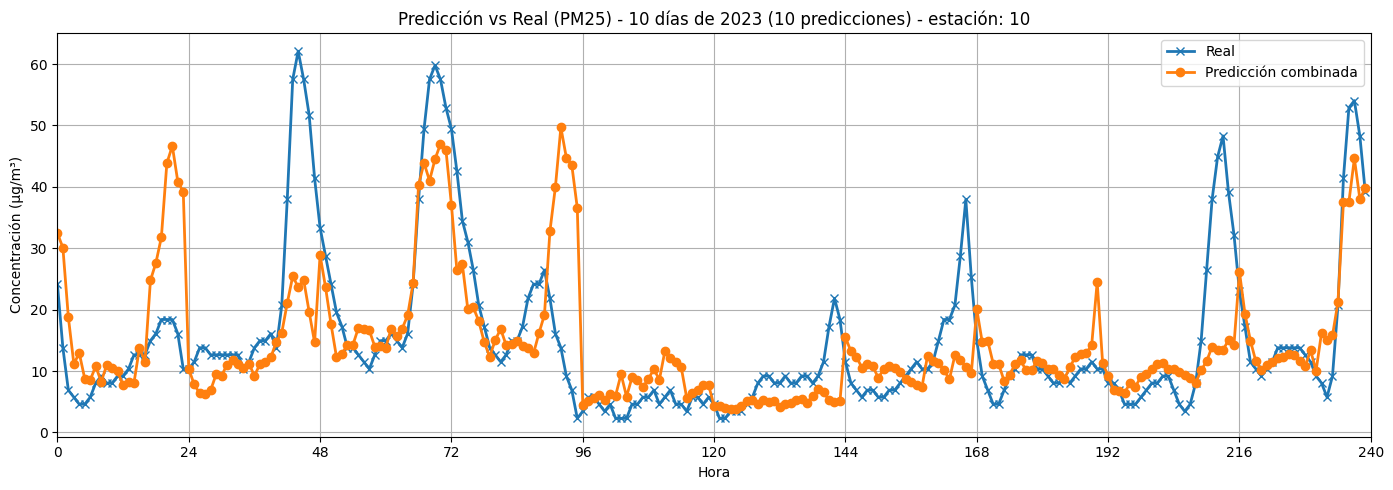

In [ ]:
# Concatenar 10 días de predicción
pred_240 = np.concatenate([y_pred_24_2023[i] for i in range(0, 240, 24)])
real_240 = np.concatenate([y_24_2023.iloc[i].values for i in range(0, 240, 24)])

x = np.arange(240)
df_plot = pd.DataFrame({
    'Hora': x,
    'Real': real_240,
    'Predicción combinada': pred_240
})

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(df_plot['Hora'], df_plot['Real'], label='Real', marker='x', linewidth=2)
plt.plot(df_plot['Hora'], df_plot['Predicción combinada'], label='Predicción combinada', marker='o', linewidth=2)
plt.xlabel('Hora')
plt.ylabel('Concentración (μg/m³)')
plt.title(f'Predicción vs Real ({contaminante}) - 10 días de 2023 (10 predicciones) - estación: {estacion}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(ticks=np.arange(0, 241, 24))  # Por ejemplo, un tick cada 24 horas
plt.xlim(0, 240)
plt.show()



# Modelo ensemble stacking

In [ ]:
from collections import defaultdict

resultados = defaultdict(lambda: {"pred": [], "real": []})

# Avanzar en saltos de 24 filas para evitar solapamiento
for bloque_num, i in enumerate(range(0, len(X_test) - 25, 24)):
    X_bloque = X_test.iloc[i:i + 25].copy().reset_index(drop=True)
    y_bloque = y_test.iloc[i:i + 25].reset_index(drop=True)

    mostrar = bloque_num < 3
    if mostrar:
        print(f"\n======= BLOQUE {bloque_num + 1} (filas {i} a {i + 24}) =======")

    preds, reals = predecir_24h_iterativo(modelo_1h, X_bloque, y_bloque, mostrar=mostrar)
    print(i)
    for h in range(24):
        resultados[h + 1]["pred"].append(preds[h])
        resultados[h + 1]["real"].append(reals[h])



======= BLOQUE 1 (filas 0 a 24) =======

Iteración h = 0
→ Predicción para t = 1: 13.83
→ Lags de CONCENTRACION usados como input: {'CONCENTRACION_lag1': np.float64(12.87), 'CONCENTRACION_lag2': np.float64(12.87), 'CONCENTRACION_lag3': np.float64(10.53), 'CONCENTRACION_lag4': np.float64(8.19), 'CONCENTRACION_lag5': np.float64(8.19), 'CONCENTRACION_lag6': np.float64(16.38), 'CONCENTRACION_lag7': np.float64(25.74), 'CONCENTRACION_lag8': np.float64(23.4), 'CONCENTRACION_lag9': np.float64(14.04), 'CONCENTRACION_lag10': np.float64(11.7), 'CONCENTRACION_lag11': np.float64(7.02), 'CONCENTRACION_lag12': np.float64(8.19), 'CONCENTRACION_lag13': np.float64(10.53), 'CONCENTRACION_lag14': np.float64(5.85), 'CONCENTRACION_lag15': np.float64(7.604999999999999), 'CONCENTRACION_lag16': np.float64(9.36), 'CONCENTRACION_lag17': np.float64(11.114999999999998), 'CONCENTRACION_lag18': np.float64(12.87), 'CONCENTRACION_lag19': np.float64(12.87), 'CONCENTRACION_lag20': np.float64(9.36), 'CONCENTRACION_lag21

In [ ]:
resultados_2023_1h = defaultdict(lambda: {"pred": [], "real": []})

# Avanzar en saltos de 24 filas para evitar solapamiento
for bloque_num, i in enumerate(range(0, len(X_2023) - 25, 24)):
    X_bloque = X_2023.iloc[i:i + 25].copy().reset_index(drop=True)
    y_bloque = y_2023.iloc[i:i + 25].reset_index(drop=True)

    mostrar = bloque_num < 3
    if mostrar:
        print(f"\n======= BLOQUE {bloque_num + 1} (filas {i} a {i + 24}) =======")

    preds, reals = predecir_24h_iterativo(modelo_1h, X_bloque, y_bloque, mostrar=mostrar)
    print(i)
    for h in range(24):
        resultados_2023_1h[h + 1]["pred"].append(preds[h])
        resultados_2023_1h[h + 1]["real"].append(reals[h])



======= BLOQUE 1 (filas 0 a 24) =======

Iteración h = 0
→ Predicción para t = 1: 32.53
→ Lags de CONCENTRACION usados como input: {'CONCENTRACION_lag1': np.float64(40.25), 'CONCENTRACION_lag2': np.float64(34.5), 'CONCENTRACION_lag3': np.float64(32.2), 'CONCENTRACION_lag4': np.float64(31.05), 'CONCENTRACION_lag5': np.float64(29.9), 'CONCENTRACION_lag6': np.float64(19.55), 'CONCENTRACION_lag7': np.float64(6.9), 'CONCENTRACION_lag8': np.float64(4.6), 'CONCENTRACION_lag9': np.float64(1.15), 'CONCENTRACION_lag10': np.float64(0.0), 'CONCENTRACION_lag11': np.float64(1.15), 'CONCENTRACION_lag12': np.float64(4.6), 'CONCENTRACION_lag13': np.float64(9.2), 'CONCENTRACION_lag14': np.float64(10.35), 'CONCENTRACION_lag15': np.float64(11.5), 'CONCENTRACION_lag16': np.float64(10.35), 'CONCENTRACION_lag17': np.float64(6.9), 'CONCENTRACION_lag18': np.float64(5.75), 'CONCENTRACION_lag19': np.float64(3.45), 'CONCENTRACION_lag20': np.float64(4.6), 'CONCENTRACION_lag21': np.float64(6.9), 'CONCENTRACION_lag

In [ ]:
metricas_por_hora = []

for h in range(1, 25):
    y_true = resultados[h]["real"]
    y_pred = resultados[h]["pred"]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metricas_por_hora.append({
        "hora_predicha": h,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

df_metricas = pd.DataFrame(metricas_por_hora)



In [ ]:
# Calcular la media de cada métrica
promedios = {
    "hora_predicha": "Media",
    "RMSE": df_metricas["RMSE"].mean(),
    "MAE": df_metricas["MAE"].mean(),
    "R2": df_metricas["R2"].mean()
}

# Añadir como nueva fila al DataFrame
df_metricas = pd.concat([df_metricas, pd.DataFrame([promedios])], ignore_index=True)


In [ ]:
metricas_por_hora = []

for h in range(1, 25):
    y_true = resultados_2023_1h[h]["real"]
    y_pred = resultados_2023_1h[h]["pred"]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metricas_por_hora.append({
        "hora_predicha": h,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

df_metricas_2023 = pd.DataFrame(metricas_por_hora)

# Calcular la media de cada métrica
promedios = {
    "hora_predicha": "Media",
    "RMSE": df_metricas_2023["RMSE"].mean(),
    "MAE": df_metricas_2023["MAE"].mean(),
    "R2": df_metricas_2023["R2"].mean()
}

# Añadir como nueva fila al DataFrame
df_metricas_2023 = pd.concat([df_metricas_2023, pd.DataFrame([promedios])], ignore_index=True)


In [ ]:
df_metricas_2023

,hora_predicha,RMSE,MAE,R2
0,1,2.724910,2.100067,0.919809
1,2,3.348144,2.535133,0.830357
2,3,3.707391,2.690938,0.706479
3,4,3.729194,2.772560,0.609731
4,5,3.840324,2.801158,0.524923
5,6,3.948155,2.966747,0.490134
6,7,4.707928,3.340605,0.400980
7,8,5.651206,3.776105,0.289920
8,9,5.860232,4.239620,0.197458
9,10,6.137729,4.581072,0.116481


In [ ]:
# Diccionario para agrupar valores por hora futura (1 a 24)
resultados_24h = defaultdict(lambda: {"pred": [], "real": []})

# Recorremos cada bloque de predicción y sus reales
for y_pred_block, y_real_block in zip(y_pred_24, y_test_24.values):
    for h in range(24):
        y_pred = y_pred_block[h]
        y_real = y_real_block[h]

        resultados_24h[h + 1]["pred"].append(y_pred)
        resultados_24h[h + 1]["real"].append(y_real)




In [ ]:
resultados_24h_2023 = defaultdict(lambda: {"pred": [], "real": [], "naive": []})

for y_pred_block, y_real_block, y_naive_block in zip(
    y_pred_24_2023, y_24_2023.values, y_naive_24_2023.values
):
    for h in range(24):
        y_pred = y_pred_block[h]
        y_real = y_real_block[h]
        y_naive = y_naive_block[h]

        resultados_24h_2023[h + 1]["pred"].append(y_pred)
        resultados_24h_2023[h + 1]["real"].append(y_real)
        resultados_24h_2023[h + 1]["naive"].append(y_naive)


In [ ]:
metricas_24h = []

for h in range(1, 25):
    y_true = resultados_24h[h]["real"]
    y_pred = resultados_24h[h]["pred"]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metricas_24h.append({
        "hora_predicha": h,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

df_metricas_24h = pd.DataFrame(metricas_24h)

# Añadir fila con promedio
promedios_24h = {
    "hora_predicha": "Media",
    "RMSE": df_metricas_24h["RMSE"].mean(),
    "MAE": df_metricas_24h["MAE"].mean(),
    "R2": df_metricas_24h["R2"].mean()
}

df_metricas_24h = pd.concat([df_metricas_24h, pd.DataFrame([promedios_24h])], ignore_index=True)


In [ ]:
metricas_24h = []

for h in range(1, 25):
    y_true = resultados_24h_2023[h]["real"]
    y_pred = resultados_24h_2023[h]["pred"]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metricas_24h.append({
        "hora_predicha": h,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

df_metricas_24h_2023 = pd.DataFrame(metricas_24h)

# Añadir fila con promedio
promedios_24h = {
    "hora_predicha": "Media",
    "RMSE": df_metricas_24h_2023["RMSE"].mean(),
    "MAE": df_metricas_24h_2023["MAE"].mean(),
    "R2": df_metricas_24h_2023["R2"].mean()
}

df_metricas_24h_2023 = pd.concat([df_metricas_24h_2023, pd.DataFrame([promedios_24h])], ignore_index=True)

In [ ]:
df_metricas_24h_2023

,hora_predicha,RMSE,MAE,R2
0,1,3.184156,2.073758,0.897748
1,2,4.867366,3.070323,0.761883
2,3,5.962559,3.728785,0.643463
3,4,6.660556,4.188593,0.555767
4,5,7.067706,4.431429,0.500210
5,6,7.251969,4.493850,0.473987
6,7,7.466306,4.645360,0.442534
7,8,7.862024,4.851738,0.381917
8,9,7.895286,4.892806,0.376763
9,10,7.891376,4.944831,0.377427


In [ ]:
n_bloques = len(resultados[1]['pred'])

preds_1h = []
reals = []

for i in range(n_bloques):
    fila_pred = [resultados[h]['pred'][i] for h in range(1, 25)]
    fila_real = [resultados[h]['real'][i] for h in range(1, 25)]
    preds_1h.append(fila_pred)
    reals.append(fila_real)

# Convertir a DataFrames
df_preds_1h = pd.DataFrame(preds_1h, columns=[f'pred_h{h}' for h in range(1, 25)])
df_real = pd.DataFrame(reals, columns=[f'real_h{h}' for h in range(1, 25)])


In [ ]:
# Suponemos que todas las listas tienen la misma longitud = número de bloques
n_bloques = len(resultados_2023_1h[1]['pred'])

preds_1h_2023 = []
reals_2023 = []

for i in range(n_bloques):
    fila_pred = [resultados_2023_1h[h]['pred'][i] for h in range(1, 25)]
    fila_real = [resultados_2023_1h[h]['real'][i] for h in range(1, 25)]
    preds_1h_2023.append(fila_pred)
    reals_2023.append(fila_real)

# Convertir a DataFrames
df_preds_1h_2023 = pd.DataFrame(preds_1h_2023, columns=[f'pred_h{h}' for h in range(1, 25)])
df_real_2023 = pd.DataFrame(reals_2023, columns=[f'real_h{h}' for h in range(1, 25)])


In [ ]:
preds_multi = []

# Avanzamos de 24 en 24 para tomar bloques no solapados
for i in range(0, len(resultados_24h[1]['pred']), 24):
    try:
        fila = [resultados_24h[h]['pred'][i] for h in range(1, 25)]
        preds_multi.append(fila)
    except IndexError:
        break

# Convertir a DataFrame
df_preds_multi = pd.DataFrame(preds_multi, columns=[f'pred_multi_h{h}' for h in range(1, 25)])



In [ ]:
preds_multi_2023 = []

# Avanzamos de 24 en 24 para tomar bloques no solapados
for i in range(0, len(resultados_24h_2023[1]['pred']), 24):
    try:
        fila = [resultados_24h_2023[h]['pred'][i] for h in range(1, 25)]
        preds_multi_2023.append(fila)
    except IndexError:
        break

# Convertir a DataFrame
df_preds_multi_2023 = pd.DataFrame(preds_multi_2023, columns=[f'pred_multi_h{h}' for h in range(1, 25)])

In [ ]:
naive_multi_2023 = []

for i in range(0, len(resultados_24h_2023[1]['naive']), 24):
    try:
        fila = [resultados_24h_2023[h]['naive'][i] for h in range(1, 25)]
        naive_multi_2023.append(fila)
    except IndexError:
        break

df_naive_2023 = pd.DataFrame(naive_multi_2023, columns=[f'naive_h{h}' for h in range(1, 25)])


In [ ]:
n_bloques = min(len(df_preds_1h), len(df_preds_multi), len(df_real))

df_preds_1h = df_preds_1h.iloc[:n_bloques]
df_preds_multi = df_preds_multi.iloc[:n_bloques]
df_real = df_real.iloc[:n_bloques]


In [ ]:
n_bloques_2023 = min(len(df_preds_1h_2023), len(df_preds_multi_2023), len(df_real_2023), len(df_naive_2023))

df_preds_1h_2023 = df_preds_1h_2023.iloc[:n_bloques_2023]
df_preds_multi_2023 = df_preds_multi_2023.iloc[:n_bloques_2023]
df_real_2023 = df_real_2023.iloc[:n_bloques_2023]
df_naive_2023 = df_naive_2023.iloc[:n_bloques_2023]


In [ ]:
df_largo = pd.DataFrame()

for i in range(n_bloques):


    df_temp = pd.DataFrame({
        'bloque': i,
        'hora': list(range(1, 25)),
        'pred_1h': df_preds_1h.iloc[i].values,
        'pred_multi': df_preds_multi.iloc[i].values,
        'real': df_real.iloc[i].values
    })
    df_largo = pd.concat([df_largo, df_temp], ignore_index=True)



In [ ]:
df_largo_2023 = pd.DataFrame()

for i in range(n_bloques_2023):
    df_temp = pd.DataFrame({
        'bloque': i,
        'hora': list(range(1, 25)),
        'pred_1h': df_preds_1h_2023.iloc[i].values,
        'pred_multi': df_preds_multi_2023.iloc[i].values,
        'naive': df_naive_2023.iloc[i].values,
        'real': df_real_2023.iloc[i].values
    })
    df_largo_2023 = pd.concat([df_largo_2023, df_temp], ignore_index=True)



In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

X_full = df_largo[['pred_1h', 'pred_multi', 'hora']]
y_full = df_largo['real']

#modelo_combinado = GradientBoostingRegressor(n_estimators=100, random_state=42)
#modelo_combinado.fit(X_full, y_full)


In [ ]:
split_index = int(len(X_full) * 0.9)
X_subtrain_full, X_subval_full = X_full[:split_index], X_full[split_index:]
y_subtrain_full, y_subval_full = y_full[:split_index], y_full[split_index:]


param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'colsample_bytree': [1.0, 0.8]
}

xgb_base = XGBRegressor(
    objective='reg:squarederror',
    subsample=1.0,
    random_state=42
)

cv = [(np.arange(len(X_subtrain_full)), np.arange(len(X_subtrain_full), len(X_subtrain_full) + len(X_subval_full)))]
X_grid_full = np.concatenate([X_subtrain_full, X_subval_full])
y_grid_full = np.concatenate([y_subtrain_full, y_subval_full])

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_grid_full, y_grid_full)

modelo_combinado = grid_search.best_estimator_


print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 1 folds for each of 16 candidates, totalling 16 fits
Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [ ]:
# Asegúrate de tener las mismas columnas: pred_1h, pred_multi, hora
X_2023_comb = df_largo_2023[['pred_1h', 'pred_multi', 'hora']]
y_2023_comb = df_largo_2023['real']
y_naive_2023 = df_largo_2023['naive']

y_pred_2023_comb = modelo_combinado.predict(X_2023_comb)

rmse_2023 = np.sqrt(mean_squared_error(y_2023_comb, y_pred_2023_comb))
rmse_naive = np.sqrt(mean_squared_error(y_2023_comb, y_naive_2023))
mae_2023 = mean_absolute_error(y_2023_comb, y_pred_2023_comb)
r2_2023 = r2_score(y_2023_comb, y_pred_2023_comb)
mae_naive = mean_absolute_error(y_2023_comb, y_naive_2023)
mase_2023 = rmse_2023 / rmse_naive
#RMSu_2023 = calcular_RMSu(parametros[contaminante], np.mean(y_2023_comb), np.std(y_2023_comb))
#MQI_2023 = rmse_2023/(2*RMSu_2023)

print(f" RMSE en 2023: {rmse_2023:.3f}")
print(f" MAE en 2023: {mae_2023:.3f}")
print(f" R²:   {r2_2023:.3f}")
print(f" MASE: {mase_2023:.3f}")
#print(f" MQI: {MQI_2023:.3f}")

📅 RMSE en 2023: 8.287
📅 MAE en 2023: 4.774
🔹 R²:   0.285
📊 MASE: 0.709


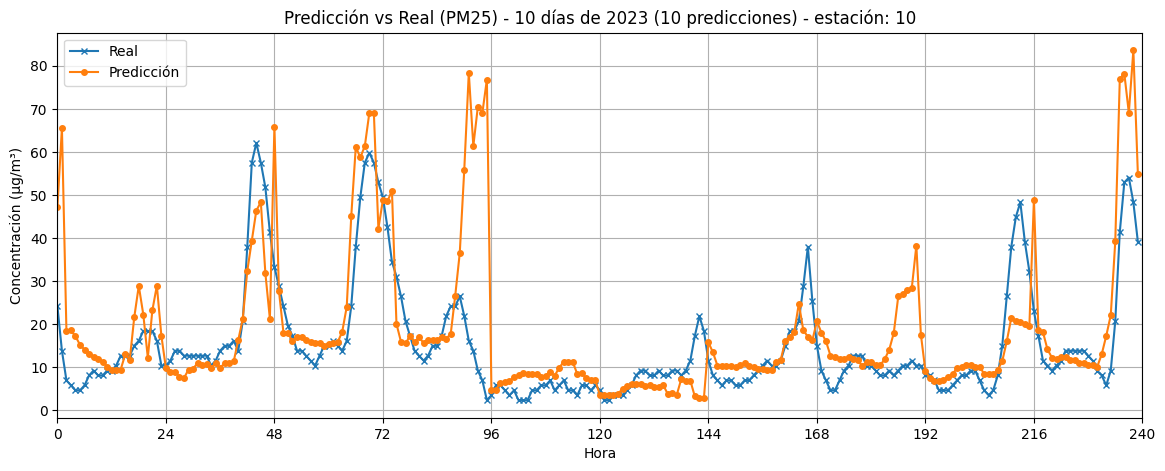

In [ ]:
primeras_24 = df_largo_2023.iloc[:240].copy()
primeras_24['y_pred'] = y_pred_2023_comb[:240]
primeras_24['y_real'] = y_2023_comb[:240].values

# Gráfico
plt.figure(figsize=(14, 5))
plt.plot( primeras_24['y_real'], label='Real', marker= 'x', markersize = 4)
plt.plot( primeras_24['y_pred'], label='Predicción', marker='o', markersize=4)
plt.xlabel('Hora')
plt.ylabel('Concentración (μg/m³)')
plt.title('Predicción vs Real (' + contaminante +') - 10 días de 2023 (10 predicciones) - estación: ' + str(estacion))
plt.legend()
plt.xlim(0, 240)
plt.xticks(ticks=np.arange(0, 241, 24))
plt.grid(True)
plt.show()
